# Finite Difference Method

이번 강의에서는 지난 강의에서 공부한 MC와 다른 가격결정 방법론인 유한차분법(Finite Difference Method)를 공부합니다.

## 1. 유한차분법의 정의

유한차분법이란, 미분방정식의 근사해를 구하는 방법론으로, 미분이 차분의 극한임을 이용하는 방법론입니다. <br>
미분방정식 안의 미분으로 표현된 항을 모두 차분으로 치환해, 미분방정식을 선형방정식 혹은 점화식으로 변경합니다.

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import norm
N = norm.cdf
def CallOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)
    
def CallUpandOutBS(S, K, T, r, q, sigma,H,P):
    if T == 0.0:
        if S>=H:
            return P
        else:
            return np.maximum(S - K, 0)
    else:
        phi = 1
        eta = -1
        mu = (r-q-0.5*sigma**2)/sigma**2
        lambd = np.sqrt(mu**2+2*r/sigma**2)
        x1 = np.log(S/K)/(sigma*np.sqrt(T)) + (1+mu)*sigma*np.sqrt(T)
        x2 = np.log(S/H)/(sigma*np.sqrt(T)) + (1+mu)*sigma*np.sqrt(T)
        y1 = np.log(H**2/(S*K))/(sigma*np.sqrt(T)) + (1+mu)*sigma*np.sqrt(T)
        y2 = np.log(H/S)/(sigma*np.sqrt(T)) + (1+mu)*sigma*np.sqrt(T)
        z = np.log(H/S)/(sigma*np.sqrt(T)) + lambd*sigma*np.sqrt(T)
        A = phi * S * np.exp((-q)*T)*N(phi*x1)-phi*K*np.exp((-r)*T)*N(phi*x1-phi*sigma*np.sqrt(T))
        B = phi * S * np.exp((-q)*T)*N(phi*x2)-phi*K*np.exp((-r)*T)*N(phi*x2-phi*sigma*np.sqrt(T))
        C = phi * S * np.exp((-q)*T)*((H/S)**(2*mu+2))*N(eta*y1)-phi*K*np.exp((-r)*T)*((H/S)**(2*mu))*N(eta*y1-eta*sigma*np.sqrt(T))
        D = phi * S * np.exp((-q)*T)*((H/S)**(2*mu+2))*N(eta*y2)-phi*K*np.exp((-r)*T)*((H/S)**(2*mu))*N(eta*y2-eta*sigma*np.sqrt(T))
        F = (((H/S)**(mu+lambd))*N(eta*z)+((H/S)**(mu-lambd))*N(eta*z-2*eta*lambd*sigma*np.sqrt(T)))*P
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        Q = (S>=H)*1
        return (P-(A-B+C-D+F))*Q+(A-B+C-D+F)

### example

유한차분법을 이용해 다음 미분방정식의 해를 구해 보겠습니다.<br>
$$ f'(x)  = f(x) , f(0) = 1 $$ <br>
미분으로 표현된 항을 차분으로 바꾸면 다음과 같습니다.<br>
For small $h$,<br>
$${f(x+h)-f(x) \over h} \approx f(x)$$<br>
위 식을 정리하면 다음과 같습니다.<br>
$$f(x+h) \approx (1+h)f(x)$$<br>
우리는 현재 $f(0)$를 알고 있으므로, 이를 이용해 $f(h)$, 또 이를 이용해 $f(2h)$ 를 구할 수 있으며,<br> 이 과정을 반복하면 미분방정식의 근사해를 구할 수 있습니다.<br>
$h = 0.1$로 설정하면, $f(0.1) = 1.1$, $f(0.2) = 1.1^2,...f(x) = 1.1^{10x}$이며 이를 실제 해인 $f(x) = e^x$와 비교하면 다음과 같습니다.

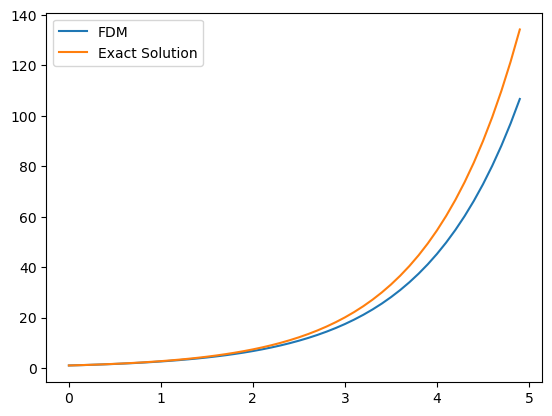

In [2]:
t1 = np.arange(0, 5.0, 0.1)
y = 1.1**(10*t1)
y2 = np.exp(t1)
plt.plot(t1, y,label = "FDM")
plt.plot(t1, y2,label = "Exact Solution")
plt.legend(loc = "upper left")
plt.show()

$h = 0.01$로 설정한 경우 $f(x) = 1.01^{100x}$이며, 결과는 다음과 같습니다.

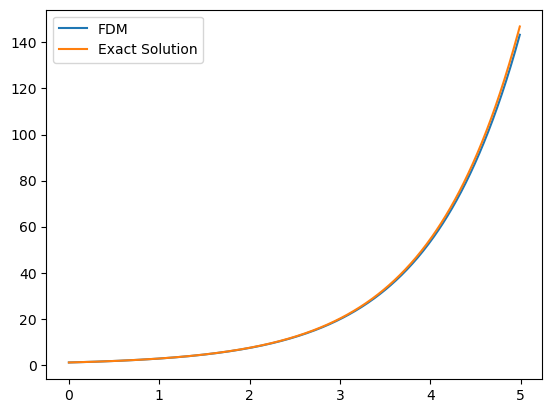

In [3]:
t1 = np.arange(0, 5.0, 0.01)
y = 1.01**(100*t1)
y2 = np.exp(t1)
plt.plot(t1, y,label = "FDM")
plt.plot(t1, y2,label = "Exact Solution")
plt.legend(loc = "upper left")
plt.show()

이처럼 변수의 간격을 작게 설정하면, 오차 또한 작아지는 것을 볼 수 있습니다.<br>
하지만 변수의 간격이 작아진다면, 그에 따라 연산 횟수도 많아지니 적당한 간격을 선택해야 합니다.

## 2. 유한차분법을 이용한 파생상품 가격결정

이제 유한차분법을 이용해 바닐라 콜옵션의 가격을 결정해 보겠습니다.
모든 파생상품의 가격 $V(S,t)$는 다음과 같은 블랙-숄즈 방정식을 푸는 것으로 구할 수 있습니다.
$${1\over 2}{\sigma^2}{S^2} {{\partial^2V\over\partial S^2}} + rS {{\partial V\over\partial S}} + {{\partial V\over\partial t}} - rV = 0$$<br>
$$V(S,T) = f(S)$$<br>
이때, $T$는 만기 시점을 의미하며, $f(S)$는 만기 시점에서 $S$에 따른 페이오프를 의미합니다.<br>
이때, 배당이 존재하는 경우 $r$을 $r-q$로 바꾸면 됩니다.<br>
즉, 블랙-숄즈 방정식은 만기 조건이 정해져 있는 미분방정식입니다.<br>
유한차분법을 이용하여 위 방정식을 차분방정식으로 치환하고, 모든 기초자산의 가격과 모든 시점에 대해 파생상품의 가격을 구하면 됩니다.즉, 모든 $V(S,t)$ 격자점의 값을 채우면 됩니다.<br>
이제 블랙-숄즈 방정식을 차분방정식으로 치환하겠습니다. 각 미분항은 다음과 같이 변환됩니다.<br><br>
For small $dS$, <br>
$${{\partial V\over\partial S}} \approx {{V(S+dS,t) - V(S-dS,t)}\over 2dS}$$ <br>
$${{\partial^2V\over\partial S^2}} \approx {{V'(S+{dS\over2},t) - V'(S-{dS\over2},t)}\over dS}$$ <br>
$${{V'(S+{dS\over2},t) - V'(S-{dS\over2},t)}\over dS} \approx {{{{V(S+dS,t)-V(S,t)}\over dS}-{{V(S,t)-V(S-dS,t)}\over dS}}\over dS}$$ <br>
$${{{{V(S+dS,t)-V(S,t)}\over dS}-{{V(S,t)-V(S-dS,t)}\over dS}}\over dS} = {{V(S+dS,t)-2V(S,t)+V(S-dS,t)}\over{dS^2}}$$ <br>
$$\therefore  {{\partial^2V\over\partial S^2}} \approx {{V(S+dS,t)-2V(S,t)+V(S-dS,t)}\over{dS^2}}$$
이때, 차분을 중앙차분으로 지정하는 이유는 계산의 용이성을 확보할 수 있고, 오차가 작아지기 때문입니다.<br>
이제 ${{\partial V\over\partial t}}$을 지정해야 하는데, ${{\partial V\over\partial t}}$을 지정하는 방법은 두 가지가 있습니다.<br><br>
For small $dt$, <br>
$${{\partial V\over\partial t}} \approx {{V(S,t+dt) - V(S,t)}\over dt} $$ <br>
$${{\partial V\over\partial t}} \approx {{V(S,t) - V(S,t-dt)}\over dt} $$ <br>
첫 번째 방법을 이용하는 것을 implicit method (함축적 방법), 두 번째 방법을 이용하는 것을 explicit method (명시적 방법)라고 합니다.<br>


### 2-1 블랙-숄즈 방정식의 차분화

이제 위 챕터에서의 결과를 이용하여 블랙-숄즈 방정식을 치환하겠습니다.<br>
우선 ${{\partial V\over\partial t}}$는 나중에 처리를 하기로 합니다. <br>
${{\partial V\over\partial t}}$와 다른 항들을 각각 우변과 좌변에 배치하면 블랙-숄즈 방정식은 다음과 같은 형태가 됩니다.<br>
$$rV - {1\over 2}{\sigma^2}{S^2} {{\partial^2V\over\partial S^2}} - rS {{\partial V\over\partial S}}  = {{\partial V\over\partial t}}$$<br>
이제 ${{\partial V\over\partial S}}, {{\partial^2 V\over{\partial S}^2}}$를 치환하면 다음과 같습니다.<br>
$$rV(S,t) - {1\over 2}{\sigma^2}{S^2}{{V(S+dS,t)-2V(S,t)+V(S-dS,t)}\over{dS^2}} - rS{{V(S+dS,t) - V(S-dS,t)}\over 2dS} = {{\partial V\over\partial t}}$$<br>
위 식을 정리하면 다음과 같습니다.<br>


$$a(S,t)V(S+dS,t) + b(S,t)V(S,t) + c(S,t)V(S-dS,t) = {{\partial V\over\partial t}}$$
$$a(S,t) = -{{\sigma^2}{S^2}\over 2{dS}^2} - {rS\over{2dS}}$$
$$b(S,t) = r + {{\sigma^2}{S^2}\over {dS}^2}$$
$$c(S,t) = -{{\sigma^2}{S^2}\over 2{dS}^2} + {rS\over{2dS}}$$<br>

여기서 함축적 방법을 사용한다면 위 방정식은 다음과 같이 치환됩니다.<br>

$$a'(S,t)V(S+dS,t) + b'(S,t)V(S,t) + c'(S,t)V(S-dS,t) = V(S,t+dt)$$
$$a'(S,t) = a(S,t)\times dt$$
$$b'(S,t) = b(S.t)\times dt + 1$$
$$c'(S,t) = c(S,t)\times dt$$<br>

명시적 방법을 사용한다면 다음과 같이 치환됩니다.<br>

$$a'(S,t)V(S+dS,t) + b'(S,t)V(S,t) + c'(S,t)V(S-dS,t) = V(S,t-dt)$$
$$a'(S,t) = a(S,t)\times -dt$$
$$b'(S,t) = b(S.t)\times -dt + 1$$
$$c'(S,t) = c(S,t)\times -dt$$<br>

알고 있는 것은 만기조건이고, 구하려고 하는 것은 현재 시점의 파생상품의 가격이니 저희는 미래의 가격을 통해 과거의 가격을 구해야 합니다.<br>즉, 함축적 방법에서 알고 있는 값은 $$V(S,t+dt)$$이고, 명시적 방법에서 알고 있는 값은 $$V(S+dS,t), V(S,t) , V(S-dS,t)$$
입니다.<br>
따라서, 명시적 방법은 알고 있는 함숫값을 가중합하여, 모르는 함숫값을 계산하는 방법으로 점화식을 풀기만 하면 되는 간편한 방법입니다.<br>
그에 비해 함축적 방법은 모르는 함숫값의 가중합이 현재 알고 있는 함숫값이라고 가정하고, 연립방정식을 풀어야 하는 비교적 번거로운 방법입니다.<br>
하지만 저희는 현재 어떤 방법이 더 정확한지 모르기 때문에, 두 방법을 모두 시행하여 비교를 진행합니다.
또, 각 시각별로 가격을 구할 때, $V(S+dS), V(S-dS)$가 존재하지 않는 $S_{max}, S_{min}$에서의 가격은, 폰 노이만의 "Neumann Condition"을 이용하여,<br><br>
$$\forall t, {{\partial^2 V(S_{max}-dS,t)\over{\partial S}^2}} = 0, {{\partial^2 V(S_{min}+dS,t)\over{\partial S}^2}} = 0$$<br>
가 만족되도록 설정하며, 위 조건은<br><br>
$${{V(S_{max},t)-2V(S_{max}-dS,t)+V(S_{max}-2dS,t)}\over{dS^2}} = 0  \Rightarrow  V(S_{max},t) = 2V(S_{max}-dS,t) - V(S_{max}-2dS,t)$$
$${{V(S_{min}+2dS,t)-2V(S_{min}+dS,t)+V(S_{min},t)}\over{dS^2}} = 0  \Rightarrow  V(S_{min},t) = 2V(S_{min}+dS,t) - V(S_{min}+2dS,t)$$<br>
를 의미합니다.

### 2-2. 명시적 방법을 통한 바닐라 콜옵션의 가격결정

간단한 명시적 방법부터 이용해 바닐라 콜옵션의 가격을 결정하겠습니다.
우선 공통적으로 다음과 같은 가정하에 가격결정을 실시합니다.
$$S = 100$$
$$r = 0.02$$
$$q = 0$$
$$K = 100$$
$$\sigma = 0.2$$
$$dS = 1$$
$$T = 1$$
$$dt = {1\over 250}$$

일어날 수 있는 모든 시나리오에 대비하기 위해서는 $S_{max}$를 충분히 큰 값으로 지정해야 합니다. 주가가 GBM을 따를 때, 만기 시점 주가의 평균 + 3 × 표준편차를 초과하는 100의 배수로 $S_{max}$를 설정합니다. $S_{min}$은 $dS$로 설정합니다. 그리고 $dS$는 5로 설정합니다.

In [4]:
S = 100
r = 0.02
K = 100
sigma = 0.2
dS = 5
T = 1
days = 250
dt = 1/250
mean = np.exp(r+0.5*sigma**2)
var = (np.exp(sigma**2)-1)*(np.exp(2*r+sigma**2))
Smax = np.ceil(mean+3*np.sqrt(var))*100 # 200

이제 기초자산의 가격과 시점을 축으로 하는 데이터프레임을 만듭니다. 격자점 사이의 간격은 $dS$와 $dt$입니다.
하지만 편의를 위해 열은 1부터 251로 만듭니다. 즉 현재 날짜가 열이 됩니다. 행은 $dS$~$S_{max}$가 됩니다

In [5]:
call1 = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))

만기의 페이오프를 입력합니다.

In [6]:
for i in call1.index:
    call1.loc[i,251] = np.maximum(i-K,0)

이제 각 시점과 주가에서의 $$a'(S,t), b'(S,t), c'(S,t)$$를 구해 다음 점화식을 완성합니다.
$$a'(S,t)V(S+dS,t) + b'(S,t)V(S,t) + c'(S,t)V(S-dS,t) = V(S,t-dt)$$
$$a'(S,t) = a(S,t)\times -dt$$
$$b'(S,t) = b(S.t)\times -dt - 1$$
$$c'(S,t) = c(S,t)\times -dt$$<br>

In [7]:
def a(S,t,dS,dt,r,sigma) :
    a1 = 0.5*((sigma*S)/dS)**2
    a2 = 0.5*r*S/dS
    return -a1-a2
def b(S,t,dS,dt,r,sigma) :
    b1 = ((sigma*S)/dS)**2
    return r + b1
def c(S,t,dS,dt,r,sigma) :
    c1 = 0.5*((sigma*S)/dS)**2
    c2 = 0.5*r*S/dS
    return -c1+c2
def ae(S,t,dS,dt,r,sigma) :
    return a(S,t,dS,dt,r,sigma) * -dt
def be(S,t,dS,dt,r,sigma) :
    return b(S,t,dS,dt,r,sigma) * -dt +1
def ce(S,t,dS,dt,r,sigma) :
    return c(S,t,dS,dt,r,sigma) * -dt

In [8]:
for i in range(1,251):
    for j in np.arange(2*dS,Smax,dS):
        S = j
        t = i/250
        part1 = ae(S,t,dS,dt,r,sigma)*call1.loc[j+dS,251-i+1]
        part2 = be(S,t,dS,dt,r,sigma)*call1.loc[j,251-i+1]
        part3 = ce(S,t,dS,dt,r,sigma)*call1.loc[j-dS,251-i+1]
        call1.loc[j,251-i] = part1+part2+part3
    call1.loc[dS,251-i] = 2*call1.loc[2*dS,251-i]-call1.loc[3*dS,251-i]
    call1.loc[Smax,251-i] = 2*call1.loc[Smax-dS,251-i]-call1.loc[Smax-2*dS,251-i]

모든 시점과 모든 기초자산가격에서의 파생상품의 가격이 구해졌습니다.<br>
아래 데이터프레임에서 $i$행$j$열의 값은, $j$번째 날에 기초자산가격이 $5\times i$일 경우의 파생상품의 가격입니다.<br>
저희가 구하려 하는 현재 시점, 기초자산가격이 100일때의 파생상품 가격은 20행1열의 값인 8.858인 것을 확인할 수 있습니다.

In [9]:
call1

,1,2,3,4,5,6,7,8,9,10,...,242,243,244,245,246,247,248,249,250,251
5.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,0.000004,0.000004,0.000004,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.0,0.000047,0.000046,0.000044,0.000043,0.000041,0.00004,0.000039,0.000037,0.000036,0.000035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45.0,0.000375,0.000364,0.000354,0.000344,0.000334,0.000325,0.000315,0.000306,0.000297,0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50.0,0.00225,0.002196,0.002143,0.002091,0.00204,0.00199,0.001941,0.001893,0.001845,0.001799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


구한 가격의 정확도를 판별하기 위해 Closed-Form Solution과 1행 $j$열 원소들의 값을 비교해 보겠습니다.

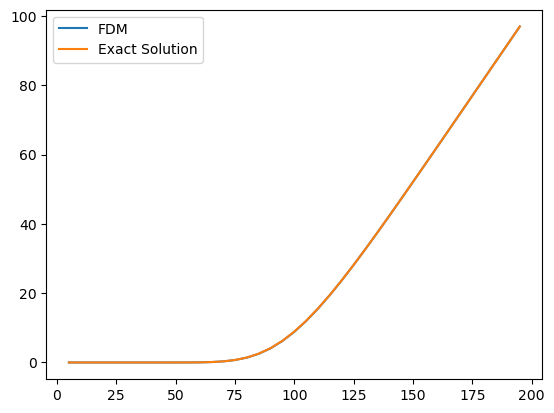

In [10]:
t1 = np.arange(dS, 200.0, dS)
y = call1.loc[t1,1]
y2 = CallOptionBS(t1, K, T, r, 0, sigma)
plt.plot(t1, y,label = "FDM")
plt.plot(t1, y2,label = "Exact Solution")
plt.legend(loc = "upper left")
plt.show()

Closed-Form Solution과 거의 같은 해가 나오는 것을 볼 수 있습니다.<br>
하지만 명시적 방법에는 치명적인 문제가 있습니다. <br>
$dS$를 조금 작게 2로 설정하고 위의 과정을 반복하면 다음과 같은 결과가 나옵니다.

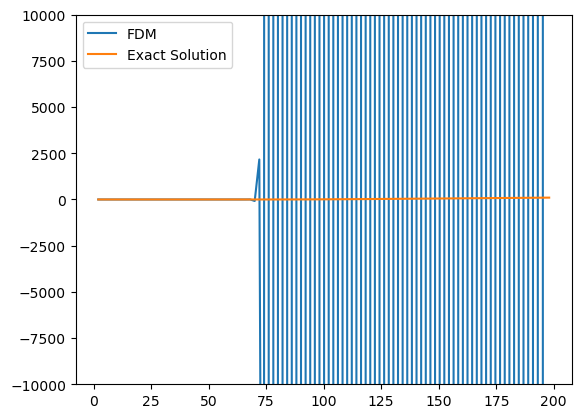

In [11]:
dS = 2
call2 = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in call2.index:
    call2.loc[i,251] = np.maximum(i-K,0)
for i in range(1,251):
    for j in np.arange(2*dS,Smax,dS):
        S = j
        t = i/250
        part1 = ae(S,t,dS,dt,r,sigma)*call2.loc[j+dS,251-i+1]
        part2 = be(S,t,dS,dt,r,sigma)*call2.loc[j,251-i+1]
        part3 = ce(S,t,dS,dt,r,sigma)*call2.loc[j-dS,251-i+1]
        call2.loc[j,251-i] = part1+part2+part3
    call2.loc[dS,251-i] = 2*call2.loc[2*dS,251-i]-call2.loc[3*dS,251-i]
    call2.loc[Smax,251-i] = 2*call2.loc[Smax-dS,251-i]-call2.loc[Smax-2*dS,251-i]
t1 = np.arange(dS, 200.0, dS)
y = call2.loc[t1,1]
y2 = CallOptionBS(t1, K, T, r, 0, sigma)
plt.plot(t1, y,label = "FDM")
plt.plot(t1, y2,label = "Exact Solution")
plt.legend(loc = "upper left")
plt.ylim(-10000,10000)
plt.show()

이처럼 $dS$가 작아지면 명시적 방법은 해를 전혀 계산하지 못하는 문제가 있습니다. <br>
답의 정확성을 위해 $dS$를 줄이게 되면 해가 나오지 않기에 일정 수준 이상의 정확성을 얻는 것이 불가능합니다. <br>
이제 함축적 FDM은 이러한 문제가 발생하지 않는지 확인하겠습니다.

### 2-2. 명시적 방법을 통한 바닐라 콜옵션의 가격결정

함축적 방법의 명시적 방법처럼 점화식으로 쉽게 풀 수가 없습니다.<br>
함축적 방법을 사용하였을 때, 블랙-숄즈 방정식은 다음과 같이 변환됩니다.<br>

$$a'(S,t)V(S+dS,t) + b'(S,t)V(S,t) + c'(S,t)V(S-dS,t) = V(S,t+dt)$$
$$a'(S,t) = a(S,t)\times dt$$
$$b'(S,t) = b(S.t)\times dt + 1$$
$$c'(S,t) = c(S,t)\times dt$$<br>

즉 현재 파생상품의 가격을 알고 있는 시점보다 과거 시점의 파생상품의 가격을 구하기 위해서 다음과 같은 연립방정식을 풀어야 합니다.<br>

$$a'(2dS,t)V(3dS,t)+b'(2dS,t)V(2dS,t)+c'(2dS,t)V(dS,t) = V(2dS,t+dt)$$
$$a'(3dS,t)V(4dS,t)+b'(3dS,t)V(3dS,t)+c'(3dS,t)V(2dS,t) = V(3dS,t+dt)$$
$$\vdots$$
$$a'(Smax-dS,t)V(Smax-2dS,t)+b'(Smax-dS,t)V(Smax-dS,t)+c'(Smax-dS,t)V(Smax,t) = V(Smax-dS,t+dt)$$
$$V(dS,t) = 2V(2dS,t)-V(3dS,t)$$
$$V(Smax,t) = 2V(Smax-dS,t)-V(Smax-2dS,t)$$
<br>
마지막 두 방정식은 다음과 같이 변형할 수 있습니다.
$$(2c'(dS,t)+b'(dS,t))V(dS,t)+(-c'(dS,t)+a'(dS,t))V(2dS,t) = V(dS,t+dt)$$
$$(c'(Smax,t)-a'(Smax,t))V(Smax-dS,t)+(b'(Smax,t)+2a'(Smax,t))V(Smax,t)= V(Smax,t+dt)$$
<br>
편의를 위해 다음과 같이 변형합니다.
$$\alpha(dS,t)V(dS,t) + \beta(dS,t)V(2dS,t) = V(dS,t+dt)$$
$$\gamma(Smax,t)V(Smax-dS,t) + \delta(dS,t)V(Smax,t) = V(Smax,t+dt)$$
<br>
이제 이 연립방정식은 다음과 같은 선형방정식으로 표현됩니다.
<br>
$$A\mathbf{x} = \mathbf{b}$$
<br>
$$A = \begin{bmatrix}
\alpha(1) & \beta(1) &\cdots &0& 0 \\
\ c(2) & b(2) & a(2) &\cdots &0 \\
\vdots & \ddots & \vdots & \vdots & \vdots \\
\ 0 & \cdots & c(max-1) & b(max-1) & a(max-1) \\
0 & \cdots & 0&\gamma(max) & \delta(max) \\
\end{bmatrix}$$

<br>

$$\mathbf{x} = \begin{bmatrix}
\ V(dS,t)  \\
\ V(2dS,t)  \\
\vdots  \\
\ V(Smax,t)\\ 
\end{bmatrix}$$

$$\mathbf{b} = \begin{bmatrix}
\ V(dS,t+dt)  \\
\ V(2dS,t+dt)  \\
\vdots  \\
\ V(Smax,t+dt)\\ 
\end{bmatrix}$$

이때, $a(n),b(n),c(n)$ 과 같은 행렬 $A$의 원소는 각각 $a'(n\times dS,t),b'(n\times dS,t),c'(n\times dS,t)$를 의미합니다.<br>
저희는 $\mathbf{b}$의 원소들의 값을 알고 있으며, $\mathbf{x}$의 원소를 구하려 하는 것이기에, <br>
$$\mathbf{x} = A^{-1}\mathbf{b}$$
의 과정을 통해 $\mathbf{x}$의 원소들의 값을 순차적으로 구해, 모든 기초자산의 가격과, 모든 시점에서의 파생상품의 가격을 구합니다.

In [12]:
dS = 1
def ai(S,t,dS,dt,r,sigma) :
    return a(S,t,dS,dt,r,sigma) * dt
def bi(S,t,dS,dt,r,sigma) :
    return b(S,t,dS,dt,r,sigma) * dt +1
def ci(S,t,dS,dt,r,sigma) :
    return c(S,t,dS,dt,r,sigma) * dt

In [13]:
call3 = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in call3.index:
    call3.loc[i,251] = np.maximum(i-K,0)

행렬 $A$를 구축하는 함수를 만듭니다.

In [14]:
def matrix(Smax,t,dS,dt,r,sigma):
    N = int(Smax/dS)
    mat = np.zeros([N,N])
    mat[0,0] = 2*ci(dS,t,dS,dt,r,sigma)+bi(dS,t,dS,dt,r,sigma)
    mat[0,1] = -ci(dS,t,dS,dt,r,sigma)+ai(dS,t,dS,dt,r,sigma)
    for i in range(1,N-1):
        mat[i,i-1] = ci((i+1)*dS,t,dS,dt,r,sigma)
        mat[i,i] = bi((i+1)*dS,t,dS,dt,r,sigma)
        mat[i,i+1] = ai((i+1)*dS,t,dS,dt,r,sigma)
    mat[N-1,N-2] = ci(Smax,t,dS,dt,r,sigma)-ai(Smax,t,dS,dt,r,sigma)
    mat[N-1,N-1] = bi(Smax,t,dS,dt,r,sigma)+2*ai(Smax,t,dS,dt,r,sigma)
    return mat

이제 i일의 파생상품의 가격 벡터에 행렬 $A$의 역행렬을 곱해 i-1일의 파생상품의 가격을 구합니다.

In [15]:
for i in range(1,251):
    t = (251-i)/250
    v = np.array(call3[251-i+1])
    call3[251-i] = np.linalg.inv(matrix(Smax,t,dS,dt,r,sigma))@v

구한 가격의 정확도를 판별하기 위해 Closed-Form Solution과 1행 $j$열 원소들의 값을 비교해 보겠습니다.

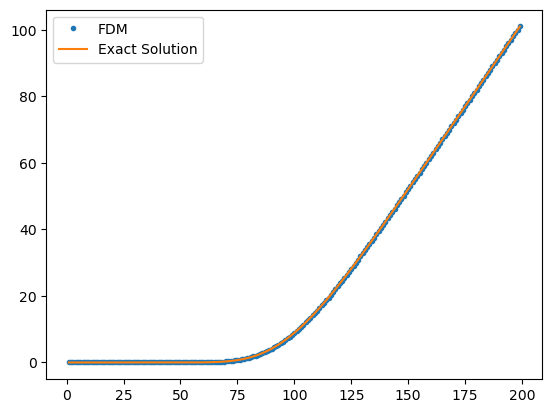

In [16]:
t1 = np.arange(dS, 200.0, dS)
y = call3.loc[t1,1]
y2 = CallOptionBS(t1, K, T, r, 0, sigma)
plt.plot(t1, y,".",label = "FDM")
plt.plot(t1, y2,label = "Exact Solution")
plt.legend(loc = "upper left")
plt.show()

$dS$가 1이라는 작은 값임에도 Closed-Form Solution과 거의 같은 해가 나오는 것을 볼 수 있습니다. <br>
명시적 방법의 수렴성 문제가 함축적 방법에서는 일어나지 않는 것을 확인할 수 있습니다. <br>
따라서 이후 과정에서 FDM은 모두 함축적 방법으로 진행합니다.

## 3. 유한차분법을 이용한 배리어 옵션 가격결정

위의 방법으로 기초적인 파생상품은 가격결정이 가능하지만, 어떠한 조건이 발생했을 때 페이오프가 변하는 파생상품, 예를 들어 낙인 ELS와 같은 상품은 가격결정이 불가능합니다. 따라서 일반적인 경우에는 바닐라 콜옵션과 같은 페이오프를 가지지만, 주가가 한 번이라도 일정 수준 이상에 도달한 경우 0의 페이오프를 지급하는 Up-and-Out 배리어 옵션의 가격결정을 실행해 보겠습니다.<br>
일정 조건 달성 시 페이오프가 변하는 파생상품의 가격결정은 다음과 같이 진행됩니다.<br>

1. 조건 달성 시의 페이오프를 만기 페이오프로 가지는 파생상품의 가격 격자를 완성합니다.

2. 파생상품의 가격결정을 시행합니다. 이때, 각 시점의 가격을 계산한 후, 조건이 달성된 부분의 가격을 1의 격자점의 가격으로 교체합니다.

3. 2의 과정을 모든 시점에 대해 시행해 초기 파생상품의 가격을 계산합니다.

배리어 옵션은 이전 과정에서 실시한 바닐라 옵션과 모든 조건이 똑같고, 한 번이라도 주가가 150 이상을 달성한 경우 만기에서 무조건 10의 페이오프를 가진다고 설정합니다. 즉 만기 주가가 0 이상 100미만 일 때는 0, 100 이상 150 미만일 때는 $S_T - 100$, 150 이상일 때는 20을 만기 페이오프로 가집니다.<br>
우선 1의 과정에 해당하는 격자점인 Knock 격자점을 만듭니다.<br>
조건 달성 시, 해당 파생상품은 만기에 무조건 20의 페이오프를 주므로 만기가 $t$년 남았을 때, 해당 파생상품의 가격은 $20*e^{-rt}$입니다.

In [17]:
Knock = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in Knock.index:
    Knock.loc[i,251] = 20
for i in range(1,251):
    t = (251-i)/250
    Knock[251-i] = 20*np.exp(-r*t)

이제 배리어 옵션의 가격을 결정합니다. <br>
만기의 페이오프를 설정하고, t기의 가격을 이용해 t-1기의 가격을 만든 뒤, 배리어 조건을 만족하는 부분인 $S_t\ge150$의 부분을 같은 위치의 Knock 격자점의 값으로 대체하면 됩니다. 

In [18]:
Barrier = pd.DataFrame(index = np.arange(dS,Smax+dS,dS), columns = range(1,252))
for i in Barrier.index:
    Barrier.loc[i,251] = np.maximum(i-K,0)
    if i>=150:
        Barrier.loc[i,251] = 10

for i in range(1,251):
    t = (251-i)/250
    v = np.array(Barrier[251-i+1])
    Barrier[251-i] = np.linalg.inv(matrix(Smax,t,dS,dt,r,sigma))@v
    Barrier[251-i][150:] = np.array(Knock.loc[150:,251-i])

구한 가격의 정확도를 판별하기 위해 Closed-Form Solution과 1행 $j$열 원소들의 값을 비교해 보겠습니다.

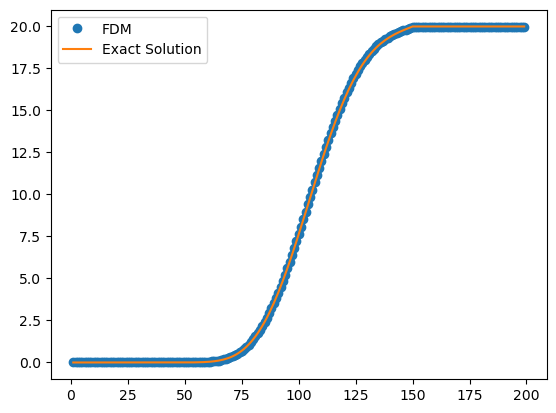

In [21]:
t1 = np.arange(dS, 200.0, dS)
y = Barrier.loc[t1,1]
y2 = CallUpandOutBS(t1, K, T, r, 0, sigma,150,20)
plt.plot(t1, y,'o',label = "FDM")
plt.plot(t1, y2,label = "Exact Solution")
plt.legend(loc = "upper left")
plt.show()

Closed-Form Solution과 거의 같은 해가 나오는 것을 볼 수 있습니다.